<font size="9">Finding over-represented functions within a proteomic sample<font size="9">

Given a single proteomic sample with an accompanying metagenome, our goal in this notebook is to suggest functional annotations which may be overrepresented among the identified proteins. 
To do this we:

1) Access the sample records with API endpoints.

2) Download the protein report for the sample, as well as the functional GFF of the searched metaproteome.

3) Count the number of times each annotation appeared and find the hypergeometric statistics.

4) Summarize the results and significance with a plot.

In [45]:
library(httr)
library(hash)
library(ape)
library(data.table)
library(dplyr)
library(rtracklayer)
library(ggplot2)
library(grid)
library(gridExtra)

biosample_id = "nmdc:bsm-13-bgefg837"

<font size="9">Accessing records through API<font size="9">

Given a biosample id, we first access the biosample information on the NMDC using the 'find/biosample' endpoint. From this response we obtain the
studyid associated with the biosample. 

Then, using the studyid, we find all data objects associated to that biosample, with help from the 'find/data_objects/study/study_id' endpoint. 
We store just the relevant information in the output, meaning we keep only the protein_reports for the biosample, the associated FASTA and the GFF.  
The functions above help to automate this process. 

In [4]:
get_reports_biosample <- function(biosample_id){
   
   biosample_id_ = sub(":", "%3A", biosample_id)
   url = sprintf("https://api.microbiomedata.org/biosamples/%s", biosample_id_)
   data = rjson::fromJSON(file = url)
   studyids = data[["associated_studies"]]
   if (length(studyids) > 1){
      print("More than one study associated with biosample.")
      print(studyids)
      print(sprintf("Selecting %s", studyids[[1]]))
   }
   studyid = studyids[[1]]
   all_results = get_reports_studyid(studyid)
   all_results = all_results[[sprintf("biosample_%s", biosample_id)]]
   
   gffs = all_results[["GFF"]]
   descriptions = lapply(1:length(gffs), function(x) gffs[[x]][["description"]])
   gffs = gffs[grepl("Functional Annotation for ", descriptions)]
   
   ## This will stop if multiple gffs are found. When Kaiko results start showing in the portal, we'll need to modify the code to link to the correct protein report.
   stopifnot(length(gffs) == 1)
   all_results$FASTA = all_results$FASTA[[1]]
   all_results$GFF = gffs[[1]]
   return(all_results)
}

get_reports_studyid <- function(studyid){
   studyid = sub(":", "%3A", studyid)
   url = sprintf("https://api.microbiomedata.org/data_objects/study/%s", studyid)
   all_results = hash()
   data = rjson::fromJSON(file = url)
   for (biosample in data){
      biosample_id = biosample[["biosample_id"]]
      new_entry = hash()
      data_objects = biosample[["data_objects"]]
      for (dobj in data_objects){
         if ("data_object_type" %in% names(dobj)){
            if (dobj[["data_object_type"]] == "Protein Report"){
               if ("protein_reports" %in% keys(new_entry)){
                  new_entry[["protein_reports"]] = append(new_entry[["protein_reports"]], list(dobj))
               } else {
                  new_entry[["protein_reports"]] = list(dobj)
               }
            }
            else if (grepl("FASTA", dobj[["data_object_type"]])){
               if ("FASTA" %in% keys(new_entry)){
                  new_entry[["FASTA"]] = append(new_entry[["FASTA"]], list(dobj))
               } else {
                  new_entry[["FASTA"]] = list(dobj)
               }
            }
            else if (grepl("GFF", dobj[["data_object_type"]])){
               if ("GFF" %in% keys(new_entry)){
                  new_entry[["GFF"]] = append(new_entry[["GFF"]], list(dobj))
               } else {
                  new_entry[["GFF"]] = list(dobj)
               }
            }
         }
      }
      if (length(new_entry[["protein_reports"]]) > 0){
         # check_pr_fasta(new_entry)
         all_results[[sprintf("biosample_%s", biosample_id)]] = new_entry
      }
   }
   return(all_results)
}

# debug(get_reports_biosample)

For our purposes, the function of interest here is `get_reports_biosample`:

In [5]:
test = get_reports_biosample(biosample_id)

Below we can see an example of the API response. It contains:

1) All the protein reports for that biosample (usually a single file).

2) The associated FASTA

3) The Functional GFF for the biosample. 

Note that only the functional annotation GFF is kept in these results. It contains all the relevant annotations (pfam, COG, etc) in a single GFF. Each of entry has a 'url' field, which lets us access the actual file.

In [6]:
test

<hash> containing 3 key-value pair(s).
  FASTA : nmdc:dob.... nmdc_wfm.... FASTA Am....    569196371 d23180f5.... Annotati.... https://.... nmdc:Dat....
  GFF : nmdc:dob.... nmdc_wfm.... Function....    655257131 36bdc0dc.... Function.... https://.... nmdc:Dat....
  protein_reports : nmdc:dob.... nmdc:dob.... nmdc:dob.... nmdc:dob....

<font size="9">Download protein report and GFF<font size="9">

To access these files via R, we use the associated url as the path. 

We want to read the protein reports associated with the sample. Each of these reports is made from the .raw files associated with the sample, and lists the annotations for each of the identified proteins. If there are multiple protein reports per raw file, by default we select the latest protein report generated by a 'matched_metagenome' metaproteomic workflow. If this is not possible, we alert the user and print information for all the protein reports we have, to allow the user to supply a new 'workflow_type' value to use. 

Likewise, we use the `rtracklayer` package to read in the GFF annotations. This is typically a large file (over 600Mb) so it can take a few minutes to download and to process.
The resulting dataframe has annotations listed for ALL of the proteins that were searched when producing the protein report, with each annotation category (like pfam) in its own column.

In [7]:
read_protein_report <- function(results_dict, workflow_type = 'matched_metagenome'){
   df = data.frame()
   by_name = hash()
   for (protein_report in results_dict[["protein_reports"]]){
      if ("was_generated_by" %in% names(protein_report)){
         wrkflw_id = sub("nmdc:", "", protein_report[['was_generated_by']])
         url = sprintf('https://api.microbiomedata.org/objects/%s', wrkflw_id)
         data = rjson::fromJSON(file = url)
         protein_report[['completion_date']] = data[['ended_at_time']]
         protein_report[['workflow_type']] = data[['metaproteomics_analysis_category']]
      } else{
         protein_report[['completion_date']] = ''
         protein_report[['workflow_type']] = ''
      }
      name = protein_report[['name']]
      if (name %in% keys(by_name)){
         by_name[[name]] = append(by_name[[name]], list(protein_report))
      } else {
         by_name[[name]] = list(protein_report)
      }
   }
   to_read = hash()
   workflows = lapply(keys(by_name), function(x) lapply(by_name[[x]], function(y) y[["workflow_type"]] == workflow_type))
   check_workflow_present = lapply(workflows, function(x) any(x))
   lens = lapply(workflows, function(x) length(x))
   if (all(lens == 1)){
      for (name in keys(by_name)){
         for (protein_report in by_name[[name]]){
            to_read[[name]] = protein_report
         }
      }
   } else if (all(check_workflow_present)){
      for (name in keys(by_name)){
         for (protein_report in by_name[[name]]){
            if (protein_report[["workflow_type"]] == workflow_type){
               if (name %in% names(to_read)){
                  if (to_read[[name]][["completion_date"]] <= protein_report[["completion_date"]]){
                     to_read[[name]] = protein_report
                  }
               } else {
                  to_read[[name]] = protein_report
               }
            }
         }
      }
   } else {
      
   }
   if (!all(check_workflow_present)){
      print_message = sprintf("Multiple protein reports per raw file, and not all have the requested workflow type (%s).", workflow_type)
      print_message = sprintf("%s Please specify another metaproteomic_workflow_type to use.", print_message)
      print(print_message)
      for (name in keys(by_name)){
         workflow_types = sapply(by_name[[name]], function(y) y[["workflow_type"]])
         workflow_types = sapply(workflow_types, function(y) paste0("['", y, "']"))
         workflow_types = paste(workflow_types, collapse = ", ")
         print_message = sprintf("%s has the following types available: %s", name, workflow_types)
      }
   }
   
   for (name in keys(to_read)){
      protein_report = to_read[[name]]
      url = protein_report[["url"]]
      data = read.csv2(file = url, sep = "\t")
      df = rbind(df, data)
   }
   
   return(df)
}

read_gff <- function(results_dict){
   options(timeout = 500)
   url = results_dict[["GFF"]][["url"]]
   gff = readGFF(url) %>% as.data.frame()
   return(gff)
}

protein_report = read_protein_report(test)
functional_gff = read_gff(test)

Warning message in any(x):
"coercing argument of type 'list' to logical"
Warning message in any(x):
"coercing argument of type 'list' to logical"
Warning message in all(check_workflow_present):
"coercing argument of type 'list' to logical"
Warning message in all(check_workflow_present):
"coercing argument of type 'list' to logical"


Below, we have the first few rows in the protein report:

In [17]:
colnames(protein_report)

[1] "DatasetName"                  "razor_protein"               
 [3] "Product"                      "EC_Number"                   
 [5] "pfam"                         "KO"                          
 [7] "COG"                          "GeneCount"                   
 [9] "all_proteins"                 "AnnotationList"              
[11] "UniquePeptideCount"           "SummedSpectraCounts"         
[13] "SummedPeptideMASICAbundances"

In [20]:
protein_report[1:8, ] %>% select(-all_proteins, -GeneCount, -AnnotationList)

,DatasetName,razor_protein,Product,EC_Number,pfam,KO,COG,UniquePeptideCount,SummedSpectraCounts,SummedPeptideMASICAbundances
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,SpruceW_P4_15B_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0016546_2521_4134,"two-component system, cell cycle sensor histidine kinase and response regulator CckA",EC:2.7.13.3,"PF00072,PF00512,PF02518,PF08448",KO:K13587,COG0642,1.0,1.0,1306300000.0
2,SpruceW_P4_15B_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0005275_4738_7140,signal transduction histidine kinase/HAMP domain-containing protein/ActR/RegA family two-component response regulator,,"PF00072,PF00672,PF01590,PF02518",,"COG0642,COG2770,COG4567",1.0,1.0,1306300000.0
3,SpruceW_P4_15B_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0500945_1_531,"two-component system, cell cycle sensor histidine kinase and response regulator CckA",EC:2.7.13.3,PF02518,KO:K13587,COG0642,1.0,1.0,1306300000.0
4,SpruceW_P4_15B_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0492935_2_535,"two-component system, cell cycle sensor histidine kinase and response regulator CckA",EC:2.7.13.3,"PF00072,PF02518",KO:K13587,COG0784,1.0,1.0,1306300000.0
5,SpruceW_P4_15B_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0759644_2_418,signal transduction histidine kinase,,PF02518,,COG0642,1.0,1.0,1306300000.0
6,SpruceW_P4_15B_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0000796_1803_3266,signal transduction histidine kinase,,PF02518,,COG0642,1.0,1.0,1306300000.0
7,SpruceW_P4_15B_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0124023_255_1229,"two-component system, cell cycle sensor histidine kinase and response regulator CckA",EC:2.7.13.3,"PF00072,PF02518",KO:K13587,COG0784,1.0,1.0,1306300000.0
8,SpruceW_P4_15B_22Jun17_Pippin_17-04-06,nmdc:wfmgan-11-pmh0a992.1_0011832_540_1793,"two-component system, sporulation sensor kinase E",EC:2.7.13.3,"PF00512,PF02518,PF13188",KO:K13533,COG0642,1.0,1.0,1306300000.0


As well as the associated GFF:

In [22]:
functional_gff[1:8, ]

,seqid,source,type,start,end,score,strand,phase,ID,translation_table,⋯,regulatory_class,bound_moiety,intron_start,intron_end,number_of_repeats,average_repeat_length,median_repeat_length,average_spacer_length,median_spacer_length,Parent
,<fct>,<fct>,<fct>,<int>,<int>,<dbl>,<chr>,<int>,<chr>,<chr>,⋯,<chr>,<chr>,<list>,<list>,<chr>,<chr>,<chr>,<chr>,<chr>,<list>
1,nmdc:wfmgan-11-pmh0a992.1_0000001,GeneMark.hmm-2 v1.25_lic,CDS,2,127,3.81,+,0,nmdc:wfmgan-11-pmh0a992.1_0000001_2_127,11,⋯,NA,NA,,,NA,NA,NA,NA,NA,
2,nmdc:wfmgan-11-pmh0a992.1_0000001,Prodigal v2.6.3_patched,CDS,260,1072,41.70,-,0,nmdc:wfmgan-11-pmh0a992.1_0000001_260_1072,11,⋯,NA,NA,,,NA,NA,NA,NA,NA,
3,nmdc:wfmgan-11-pmh0a992.1_0000001,Prodigal v2.6.3_patched,CDS,1507,2487,16.80,+,0,nmdc:wfmgan-11-pmh0a992.1_0000001_1507_2487,11,⋯,NA,NA,,,NA,NA,NA,NA,NA,
4,nmdc:wfmgan-11-pmh0a992.1_0000001,Prodigal v2.6.3_patched,CDS,2682,3215,11.20,+,0,nmdc:wfmgan-11-pmh0a992.1_0000001_2682_3215,11,⋯,NA,NA,,,NA,NA,NA,NA,NA,
5,nmdc:wfmgan-11-pmh0a992.1_0000001,Prodigal v2.6.3_patched,CDS,3149,3775,36.00,-,0,nmdc:wfmgan-11-pmh0a992.1_0000001_3149_3775,11,⋯,NA,NA,,,NA,NA,NA,NA,NA,
6,nmdc:wfmgan-11-pmh0a992.1_0000001,GeneMark.hmm-2 v1.25_lic,CDS,3772,4971,53.53,-,0,nmdc:wfmgan-11-pmh0a992.1_0000001_3772_4971,11,⋯,NA,NA,,,NA,NA,NA,NA,NA,
7,nmdc:wfmgan-11-pmh0a992.1_0000001,Prodigal v2.6.3_patched,CDS,5079,5828,18.90,-,0,nmdc:wfmgan-11-pmh0a992.1_0000001_5079_5828,11,⋯,NA,NA,,,NA,NA,NA,NA,NA,
8,nmdc:wfmgan-11-pmh0a992.1_0000001,Prodigal v2.6.3_patched,CDS,5890,8220,67.50,-,0,nmdc:wfmgan-11-pmh0a992.1_0000001_5890_8220,11,⋯,NA,NA,,,NA,NA,NA,NA,NA,


<font size="9">Computing hypergeometric statistics<font size="9">

Next, we treat our identified proteins as a 'random sample drawn without replacement' from a larger set of proteins in the protein database, as shown below.

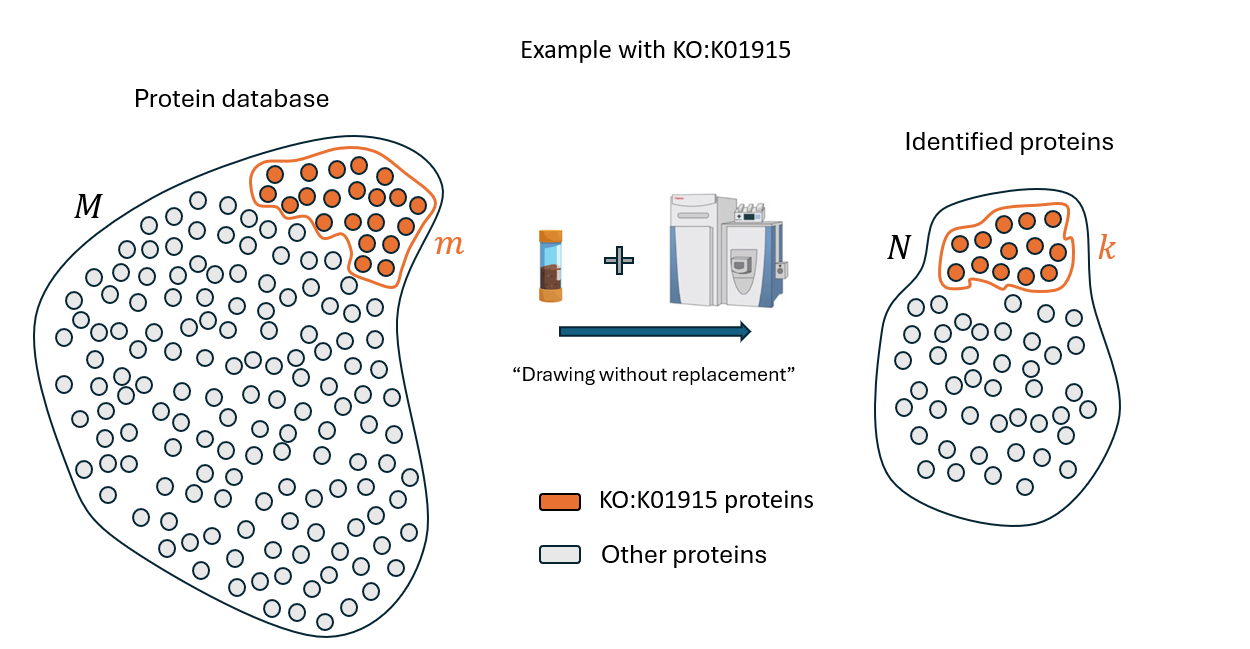

More specifically, we iterate through the protein report, counting the total number of times each annotation is identified. We also iterate through the functional GFF to count the total number of proteins that COULD have been identified for each annotation. Dictionaries are used to keep track of both of these counts. Then we use `stats`'s `phyper` function to compute the pvalues, see https://www.rdocumentation.org/packages/stats/versions/3.6.2/topics/Hypergeometric. For each given annotation $\textrm{Ann}$ we find:

1) $m = $ Number of possible proteins having the annotation $\textrm{Ann}$. This is found in the GFF. Called $n$ by the `scipy` documentation. 

2) $k = $ Number of unique identified proteins having the annotation $\textrm{Ann}$. This is found in the protein reports. Same $k$ as the `scipy` documentation.

3) $M = $ Total number of proteins searched. We find this from the GFF. Same $M$ as the `scipy` documentation.

4) $N = $ Total number of unique proteins identified. We find this from the protein reports. Same $N$ as the `scipy` documentation.

We use these counts to compute the probability of identifying at least $k$ proteins with annotation $\textrm{Ann}$, given that a total of $M$ proteins could be identified. We find this using the survival function of the hypergeometric distribution: `hypergeom.sf(k-1, M, m, N)`. The number `k-1` is used since we want the probability of identifying at least $k$ proteins with annotation $\textrm{Ann}$, and the survival function is $1 - \textrm{cdf}$.

The function below takes as input a protein report, a gff dataframe, and one of the possible annotation families outlined in the gff. Common families include: pfam, COG, EC and KO. 

DISCLAIMER: When interpreting the pvalues, it's important to keep in mind the simplfication we have made here: We are treating a complex process (protein identification) as "drawing (from the protein database) without replacement". This is a rough approximation to reality, since not every protein is equally likely to be detected for example. Likewise, two annotations can overlap, for example related Pfam domains can share many proteins, and so the counts on each annotation are not necessarily independent from each other. With that said, the hypergeometric test is meant to highlight annotations of interest for further study.

In [23]:
find_overrep <- function(protein_report, gff, annotation_category){
   if (annotation_category == "attributes"){
      avail = colnames(gff)[colnames(gff) != "attributes"]
      print("The attributes in the gff have been parsed by gffpandas. Each category can be found in a single column.")
      print(sprintf("These are the possible columns %s", paste(avail, collapse = " ")))
   }
   
   ## Count the number of occurrences of each annotation in the GFF
   gff_annotations = gff[[annotation_category]]
   annotation_counts = hash()
   
   annotation_counts_ = gff[[annotation_category]] %>% unlist() %>% table() %>% as.data.frame()
   for (index in 1:nrow(annotation_counts_)){
      annotation = toString(annotation_counts_$.[[index]])
      annotation_counts[[annotation]] = annotation_counts_$Freq[[index]]
   }
   
   ## Count the number of occurrences of each annotation from the identified proteins.
   rownames(gff) = gff[["ID"]]
   identified_proteins = protein_report[["razor_protein"]]
   identified_proteins = identified_proteins[!grepl("Contaminant", identified_proteins)] %>% unique()
   identified_annotations = gff[identified_proteins, ][[annotation_category]]
   
   identified_counts = hash()
   identified_counts_ = identified_annotations %>% unlist() %>% table() %>% as.data.frame()
   for (index in 1:nrow(identified_counts_)){
      annotation = toString(identified_counts_$.[[index]])
      identified_counts[[annotation]] = identified_counts_$Freq[[index]]
   }
   
   total_id_proteins = length(identified_proteins)
   total_proteins = nrow(gff)
   overrep_results = data.frame()
   
   for (annotation in keys(identified_counts)){
      m = annotation_counts[[annotation]]
      n = total_proteins - m
      k = total_id_proteins
      x = identified_counts[[annotation]]
      pval = phyper(x-1, m, n, k, lower.tail = FALSE, log.p = FALSE)
      ratio = sprintf("%i/%i", x, m)
      overrep_results = rbind(overrep_results, 
                              data.frame(annotation = annotation, pvalue = pval, ratio = ratio))
   }
   overrep_results$adj_pval = p.adjust(overrep_results$pval, method = "BH")

   return(overrep_results)
}

Below we show the use of the function, as well as the output it produces. Notice we report both the pvalue and the adjusted pvalue, which we obtain using the usual Benjamini-Hochberg (BH) method. We also show the number of times each annotation was identified, as well as the total number of proteins in the GFF with that annotation.

Those annotations with more proteins identified (the numerator) tend to have lower pvalues. 

In [27]:
overrep_results_df_pfam = find_overrep(protein_report, functional_gff, 'pfam')
overrep_results_df_pfam[1:8, ]

,annotation,pvalue,ratio,adj_pval
,<chr>,<dbl>,<chr>,<dbl>
1,PF00004,7.069572e-145,188/2022,7.210964e-143
2,PF00005,5.801095e-01,106/16051,7.937937e-01
3,PF00006,1.765648e-145,162/1302,2.001068e-143
4,PF00009,0.000000e+00,353/2176,0.000000e+00
5,PF00011,3.344092e-12,21/426,1.306886e-11
6,PF00012,8.301293e-71,101/1306,2.016028e-69
7,PF00013,2.206767e-36,35/223,2.206767e-35
8,PF00015,1.654641e-56,81/1067,2.860565e-55


We can use another family, like KO, to compute the results:

In [26]:
overrep_results_df_ko = find_overrep(protein_report, functional_gff, 'ko')
overrep_results_df_ko[1:8, ]

,annotation,pvalue,ratio,adj_pval
,<chr>,<dbl>,<chr>,<dbl>
1,KO:K00010,3.416200e-01,3/308,5.005779e-01
2,KO:K00012,6.648697e-03,11/673,1.324023e-02
3,KO:K00013,7.383798e-01,2/391,9.333745e-01
4,KO:K00015,5.777243e-01,1/128,7.811791e-01
5,KO:K00018,2.859133e-01,1/50,4.312726e-01
6,KO:K00019,6.334203e-01,1/149,8.375613e-01
7,KO:K00023,8.872422e-22,19/104,5.353276e-21
8,KO:K00024,2.376614e-30,37/386,1.917313e-29


We can see which annotation families we can use in the `find_overrep` function by calling `functional_gff.columns`:

In [28]:
colnames(functional_gff)

[1] "seqid"                 "source"                "type"                 
 [4] "start"                 "end"                   "score"                
 [7] "strand"                "phase"                 "ID"                   
[10] "translation_table"     "partial"               "start_type"           
[13] "product"               "product_source"        "pfam"                 
[16] "superfamily"           "cath_funfam"           "cog"                  
[19] "ko"                    "smart"                 "tigrfam"              
[22] "ec_number"             "e.value"               "model"                
[25] "accession"             "model_start"           "model_end"            
[28] "note"                  "codon"                 "used_search_mode"     
[31] "ncRNA_class"           "regulatory_class"      "bound_moiety"         
[34] "intron_start"          "intron_end"            "number_of_repeats"    
[37] "average_repeat_length" "median_repeat_length"  "average_spacer_length"
[40] "median_spacer_length"  "Parent"

All of these columns can be used to find overrepresentation of the annotations in that column. 

In [29]:
overrep_results_df_superfam = find_overrep(protein_report, functional_gff, 'superfamily')
overrep_results_df_superfam[1:8, ]

,annotation,pvalue,ratio,adj_pval
,<chr>,<dbl>,<chr>,<dbl>
1,100920,1.383769e-43,46/351,1.712012e-42
2,100934,2.973393e-28,31/267,2.326243e-27
3,100950,4.276379e-03,33/2966,1.093766e-02
4,101215,1.337959e-02,1/2,3.199216e-02
5,101262,5.452505e-01,1/117,8.506548e-01
6,101353,1.865772e-02,5/225,4.334456e-02
7,101756,4.358759e-01,1/85,7.179132e-01
8,101790,9.520577e-01,1/451,1.000000e+00


<font size="9">Summarizing results<font size="9">

Finally, we can plot these results using `pyplot`. The function below sorts the results according to their adjusted pvalue. By default we plot the top 20 most significant annotations, but we can change this by giving a different value of `N` to the function.

In [48]:
plot_results <- function(results, title = '', N = 20){
   results = results[order(results$adj_pval), ]
   results = results[1:N, ] %>%
      mutate(annotation = factor(annotation, levels = annotation),
             counts = as.numeric(sub("/[0-9]+$", "", ratio)),
             significance = -log10(adj_pval + 1e-300))
   p1 = ggplot(results, aes(y = annotation, x = counts)) + 
      geom_bar(stat = 'identity', width = 0.7, fill = "#1f77b4") + 
      theme_bw() + theme(text = element_text(size = 20))
   p2 = ggplot(results, aes(y = annotation, x = significance)) + 
      geom_bar(stat = 'identity', width = 0.7, fill = "#1f77b4") + 
      theme_bw() + theme(text = element_text(size = 20), axis.text.y = element_blank()) + ylab("") + 
      scale_x_continuous(labels = function(x) parse(text = sprintf("10^'-%s'", format(x, digits = 2))))
   
   return(grid.arrange(p1, p2, ncol = 2, top = textGrob(title, gp = gpar(fontsize = 25))))
}

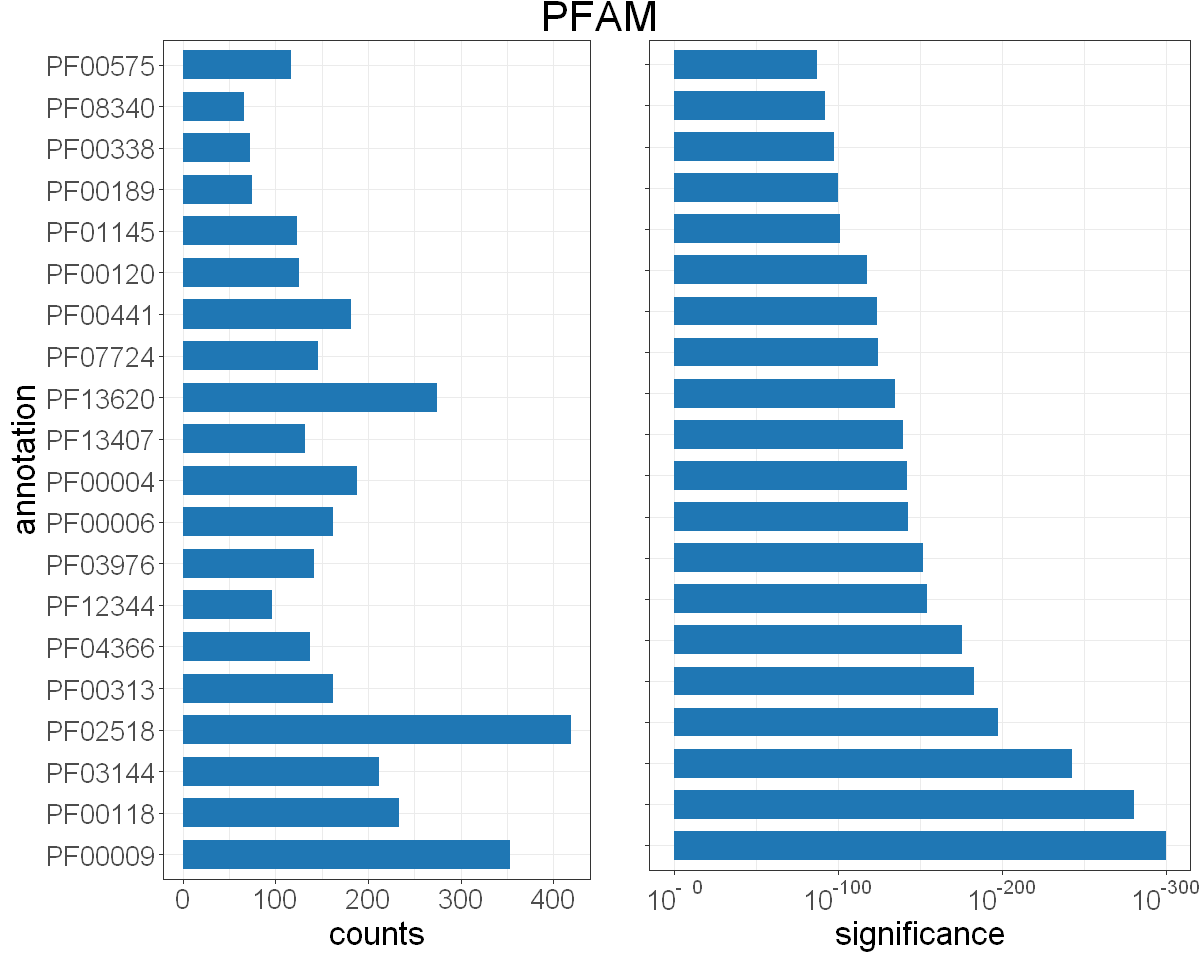

In [49]:
options(repr.plot.width=10, repr.plot.height=8)
plot_results(overrep_results_df_pfam, title = "PFAM")

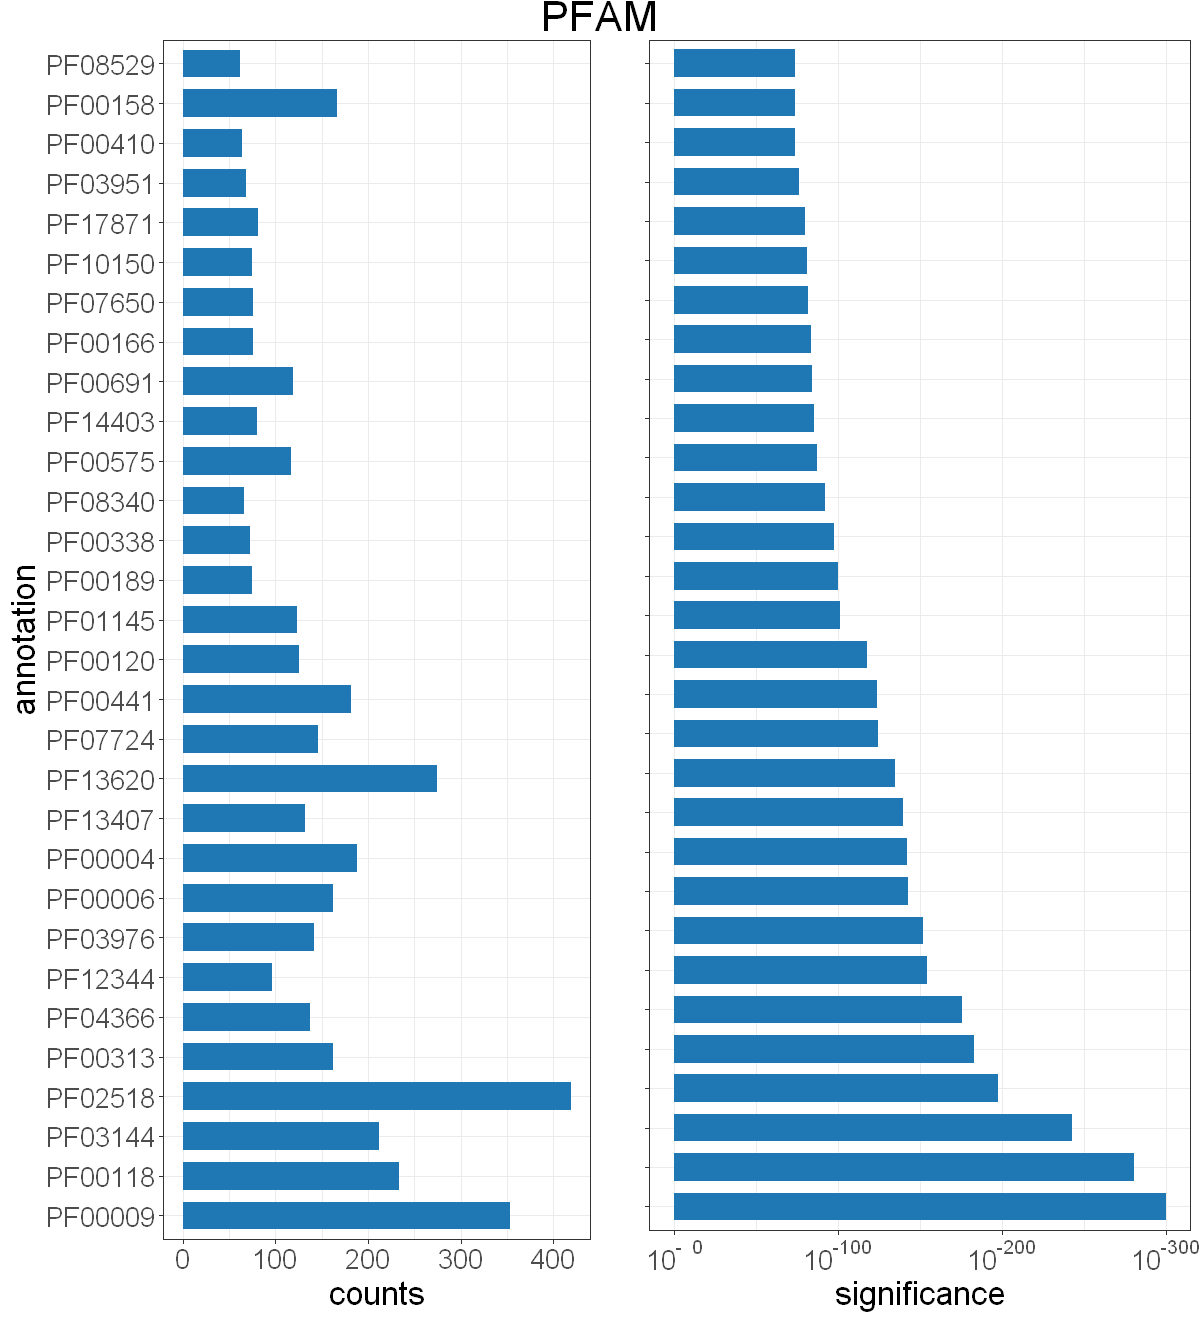

In [53]:
options(repr.plot.width=10, repr.plot.height=11)
plot_results(overrep_results_df_pfam, title = "PFAM", N=30)

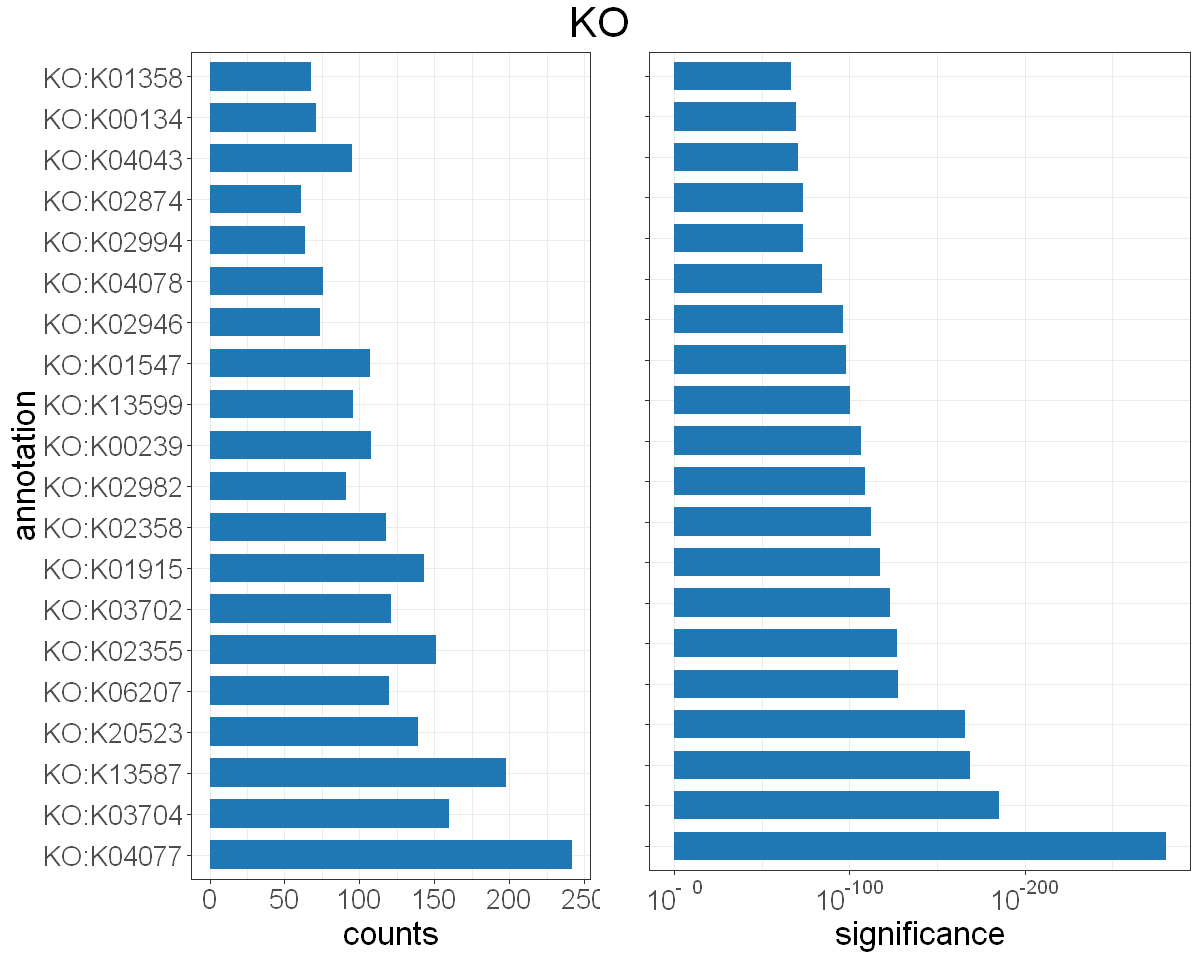

In [52]:
options(repr.plot.width=10, repr.plot.height=8)
plot_results(overrep_results_df_ko, title = "KO")

We can also visualize the overlap between any set of annotations from the GFF, using the `overlap` function below. 

In [ ]:
overlap <- function(terms, gff_df, protein_report){
   identified_proteins = protein_report[["razor_protein"]]
   identified_proteins = identified_proteins[!grepl("Contaminant", identified_proteins)] %>% unique()
   
   ## Each column contains a character containing the terms which belong to that column.
   cols_of_interest = sapply(colnames(gff_df), function(x) {
      annotations = gff_df[[x]] %>% unlist() %>% paste(., collapse = " ")
      which_terms = which(sapply(terms, function(y) grepl(y, annotations)))
      which_terms = terms[which_terms]
      list(which_terms)
   })
   
   term_members = hash()
   for (col in names(cols_of_interest)){
      for (term in cols_of_interest[[col]]){
         x = gff_df[grepl(term, gff_df[[col]]), "ID"]
         term_members[[term]] = x
      }
   }
   
   if (!(all(terms %in% keys(term_members)))){
      not_found = which(!(terms %in% keys(term_members)))
      not_found = terms[not_found]
      not_found = paste(not_found, collapse = ", ")
      print(sprintf("Warning, did not find the following terms in the GFF: %s.", not_found))
   }
   
   overlap = hash()
   for (i in 1:length(keys(term_members))){
      for (j in 1:i){
         term1 = keys(term_members)[[i]]
         term2 = keys(term_members)[[j]]
         common_members = intersect(term_members[[term1]], term_members[[term2]])
         all_members = union(term_members[[term1]], term_members[[term2]])
         x = length(common_members)/length(all_members)
         y = length(intersect(common_members, identified_proteins))/length(intersect(all_members, identified_proteins))
         
         if (x > 0){
            lab_x = format(x, digits = 2)
            lab_y = format(y, digits = 2)
         } else {
            lab_x = ""
            lab_y = ""
         }
         overlap[[paste(term1, term2, sep = "-")]] = list(x, y, lab_x, lab_y)
         overlap[[paste(term2, term1, sep = "-")]] = list(x, y, lab_x, lab_y)
         overlap[[paste(term1, term1, sep = "-")]] = list(1, 1, "", "")
         overlap[[paste(term2, term2, sep = "-")]] = list(1, 1, "", "")
      }
   }
   
   output_df = data.frame(pair = keys(overlap), 
                          overlap_background = sapply(keys(overlap), function(pair) overlap[[pair]][[1]]),
                          overlap_identified = sapply(keys(overlap), function(pair) overlap[[pair]][[2]]),
                          overlap_background_lab = sapply(keys(overlap), function(pair) overlap[[pair]][[3]]),
                          overlap_identified_lab = sapply(keys(overlap), function(pair) overlap[[pair]][[4]])) %>%
      mutate(term1 = sub("-.*$", "", pair),
             term2 = sub("^.*-", "", pair)) %>%
      select(-pair)
   
   x = tidyr::pivot_wider(output_df %>% select(term1, term2, overlap_identified), 
                          values_from = "overlap_identified", names_from = "term2")
   rownames_ = x$term1
   x = as.matrix(x[, -1])
   rownames(x) = rownames_
   labs = tidyr::pivot_wider(output_df %>% select(term1, term2, overlap_identified_lab), 
                             values_from = "overlap_identified_lab", names_from = "term2")
   rownames_ = labs$term1
   labs = as.matrix(labs[, -1])
   rownames(labs) = rownames_
   color_pal <- rev(c(colorRampPalette(c("#0f2c57", "#4896c8", "#92c4de", "white"))(15)))
   
   p = pheatmap::pheatmap(x, color = color_pal, cluster_cols = T, clustering_method = "ward.D",
                          display_numbers = labs, number_color = "white") 
   p
}

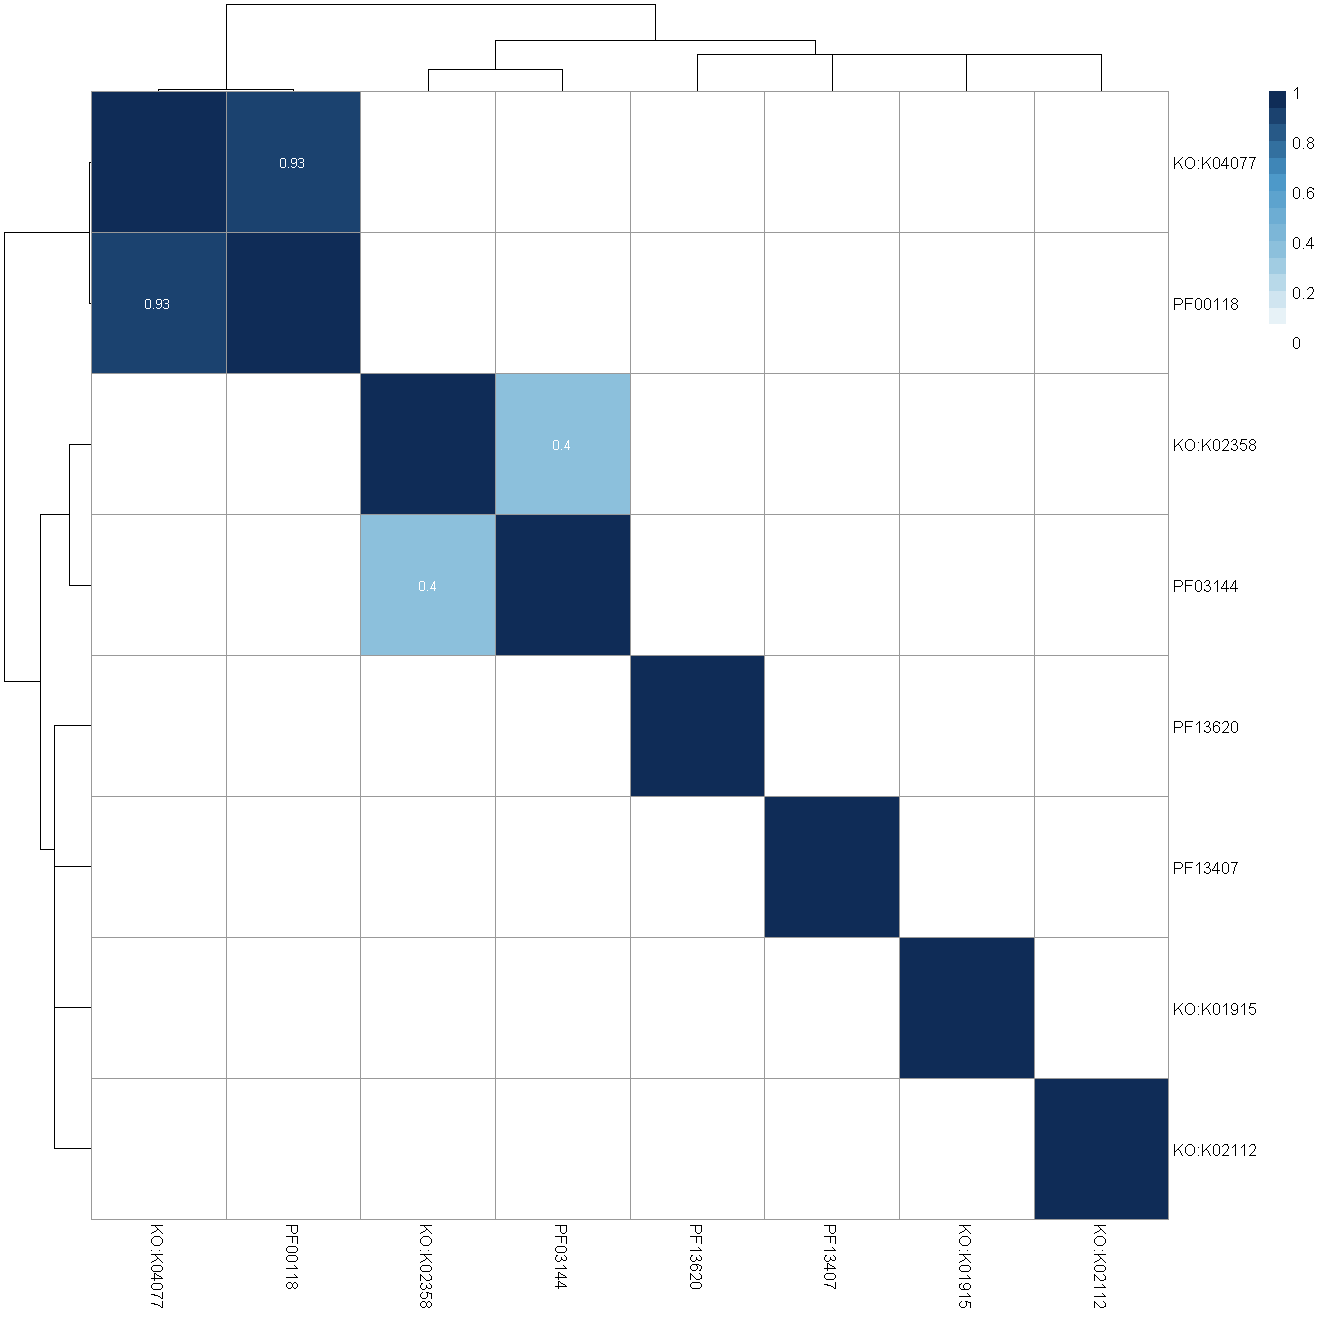

In [59]:
options(repr.plot.width=11, repr.plot.height=11)
overlap(c('KO:K04077', 'PF00118', 'PF13620', 'PF13407', 'PF03144', 'KO:K02358', 'KO:K01915', 'KO:K02112'), 
        functional_gff, protein_report)

Now, based on the barplots above, the top annotation from KO is 'KO:K04077' (https://www.genome.jp/dbget-bin/www_bget?ko:K04077), while the top annotation from PFAM is 'PF00118' (https://www.ebi.ac.uk/interpro/entry/pfam/PF00118/). In both cases we have a 'chaperonin' family of proteins associated with heat shock. As we can see from the overlap plot, these two terms share a large number of proteins, despite being from different annotation families (KO and PFAM):

Another interesting find is the kegg term 'KO:K01915' (https://www.genome.jp/dbget-bin/www_bget?ko:K01915), which has nearly 100 proteins identified and no overlap with any of the other potentially enriched annotations. This term, 'KO:K01915' is a glutamine synthetase pathway, which plays a crucial role in nitrogen metabolism - sensible given that we are dealing with a soil sample.